# Dimensionality reduction techniques comparison

### Dataset



In [1]:
def transform_key(key):
    parts = key.split('_')
    return f"{parts[0]}_{parts[-1]}"
    
def transform_key_generation(key):
    parts = list(key)
    return int(parts[1])
    
def name_image_from_key(key):
    folder = 'D:\Dropbox\CavityDesignHub\cli\cav_images'
    return fr"{folder}\\{key}.png"

In [2]:
import numpy as np
import pandas as pd
import ipyvolume as ipv
from matplotlib import cm

# create custom data from excel
# df = pd.read_excel('D:\Dropbox\CavityDesignHub\MuCol_Study\SimulationData\ConsoleTest\cavities\SimulationData\Optimisation\Generation1.xlsx', 'Sheet1')
df = pd.read_excel('D:\Dropbox\CavityDesignHub\Cavity800\SimulationData\SLANS_5cell_midcell_C3795_origin\Generation24.xlsx', 'Sheet1')
# df = pd.read_excel(fr'D:\Dropbox\CavityDesignHub\KWT_simulations\PostprocessingData\Data\grid_results.xlsx', 'Sheet1')

# process labels as generation and how it was spurned
df['target'] = df['key'] #.apply(transform_key)

objs = ["Epk/Eacc []", "Bpk/Eacc [mT/MV/m]", 'ZL [max(1<f<2)]', 'ZL [max(2<f<5)]']
geom = ['A', 'B', 'a2', 'b3', 'Ri', 'L']

feature_names = geom

dd = df[feature_names].to_numpy()
data = {'data': dd, 'feature_names': feature_names}
features = data["data"]
labels = df['target']
labels = df['Epk/Eacc']

In [3]:
pd.DataFrame(data['data'])

,0,1,2,3,4,5
0,62.222222,66.126126,30.220220,23.113113,71.986987,93.5
1,57.223449,54.245661,29.212712,29.657342,75.055942,93.5
2,53.962816,58.790930,32.614318,42.749798,67.707374,93.5
3,59.347449,61.549394,30.838722,27.809564,74.871704,93.5
4,55.305647,56.483562,28.472701,25.043429,71.264352,93.5
...,...,...,...,...,...,...
2995,69.849850,51.051051,19.609610,43.283283,62.652653,93.5
2996,51.411411,31.111111,18.558559,47.387387,63.053053,93.5
2997,41.801802,21.321321,17.757758,46.886887,62.352352,93.5
2998,62.162162,40.840841,14.654655,30.770771,61.101101,93.5


In [4]:
# generate cavity images
import sys
sys.path.append("..")
from cavsim2d.utils.shared_functions import writeCavityForMultipac

def save_cavities_contour(df_in, opt='mid'):
    keys = df_in['key']
    df_in = df_in[['A', 'B', 'a2', 'b3', 'Ri', 'L', 'Req']]
    
    min_x, max_x, min_y, max_y = [], [], [], []
    plt.rcParams["figure.figsize"] = (2.5, 3)

    for index, row in df_in.iterrows():
        mid_cell = row.values
        end_cell_left = mid_cell
        end_cell_right = mid_cell
        folder = 'D:\Dropbox\CavityDesignHub\cli\cav_images'
        writeCavityForMultipac(fr"{folder}\contour.txt", 1, 
                               mid_cell, end_cell_left, end_cell_right,
                               beampipe='none', unit=1, scale=1)

        data = pd.read_csv(fr"{folder}\contour.txt", sep=r'\s+', header=None, skiprows=3)

        # save figure
        plt.plot(data[1], data[0], lw=3., label=keys[index])
        plt.legend(loc='lower left')

        x_label = r"$z$"
        y_label = r"$r$"
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        min_x.append(min(data[1]))
        min_y.append(min(data[0]))
        max_x.append(max(data[1]))
        max_y.append(max(data[0]))
    
        plt.gca().set_aspect('equal')
        # plt.tight_layout()
        plt.savefig(fr'{folder}/{keys[index]}.png', dpi=100)
        plt.close()

# save_cavities_contour(df)
# create images column
df['images'] = df['key'].apply(name_image_from_key)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
try:
  import ipyvolume as ipv
except:
  !pip install ipyvolume -q
  import ipyvolume as ipv
  !jupyter nbextension enable --py --sys-prefix ipyvolume

def visualize_2d(x, labels):
    sns.scatterplot(x=x[:, 0], y=x[:, 1],  s=100, alpha=0.8,
                    palette="tab10", edgecolor="black")

def visualize_3d(x, labels):
    # Workaround as axis limits are not auto-scaling
    x_norm = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
    fig = ipv.figure(height=600, width=600)
    x, y, z = x_norm[:, 0], x_norm[:, 1], x_norm[:, 2]

    norm = plt.Normalize(labels.min(), labels.max())
    # Apply colormap
    colors = cm.Set2(norm(labels))
    ipv.scatter(x, y, z, size=4, marker="sphere", color=colors)
    ipv.show()

### TSNE

In [6]:
from sklearn.manifold import TSNE

%time tsne_3d = TSNE(n_components=3, perplexity=30, early_exaggeration=100, learning_rate='auto', init='pca', n_jobs=4).fit_transform(features)
visualize_3d(tsne_3d, labels)

CPU times: total: 1min 27s
Wall time: 1min 22s


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

CPU times: total: 20.4 s
Wall time: 20.1 s


C:\Users\sosoho\AppData\Local\Temp\ipykernel_13276\2821607423.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x[:, 0], y=x[:, 1],  s=100, alpha=0.8,


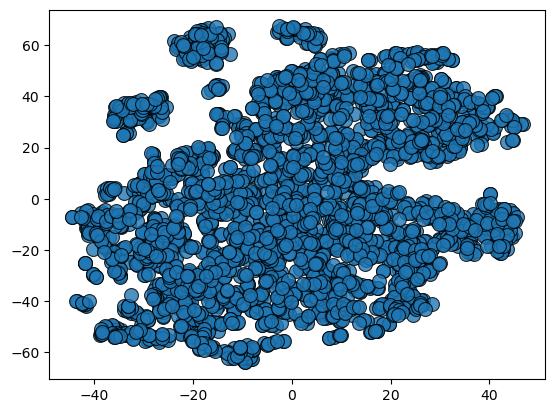

In [7]:
%time tsne_2d = TSNE(n_components=2, perplexity=30, early_exaggeration=30, learning_rate='auto', init='random', n_jobs=4).fit_transform(features)
visualize_2d(tsne_2d, labels)

In [8]:
# It's also possible to manually compute eigenvectors and eigenvalues
subset_idx = 3
cov = np.cov(features)[:subset_idx, :subset_idx]
eig_vals, eig_vecs = np.linalg.eig(cov)
print("Eigenvalues: \n", eig_vals)
print("Eigenvectors: \n", eig_vecs)

Eigenvalues: 
 [1742.89060395   38.4899812    10.74142433]
Eigenvectors: 
 [[-0.6273507  -0.69041724  0.36021539]
 [-0.60095616  0.13504254 -0.78779135]
 [-0.49526033  0.71069511  0.49962953]]


2D Projection

CPU times: total: 0 ns
Wall time: 2.99 ms


C:\Users\sosoho\AppData\Local\Temp\ipykernel_13276\2821607423.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x[:, 0], y=x[:, 1],  s=100, alpha=0.8,


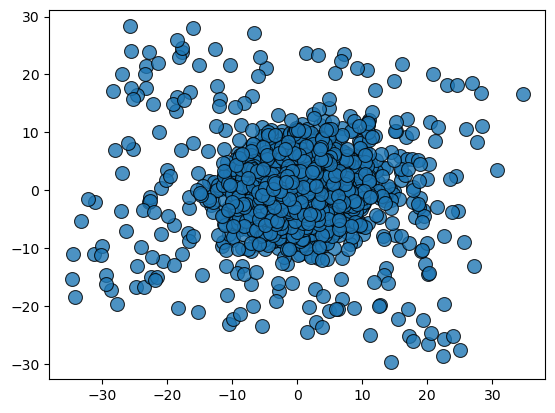

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
%time pca_2d = pca.fit_transform(features)
visualize_2d(x=pca_2d, labels=labels)

In [10]:
print("Eigenvalues: \n", pca.explained_variance_ratio_)
print("Eigenvectors: \n", pca.components_)


Eigenvalues: 
 [0.43632931 0.30621513]
Eigenvectors: 
 [[ 1.39751433e-01  9.60898639e-01  6.54134540e-02  2.22480589e-01
   5.80242216e-02  5.03474012e-16]
 [ 7.98659087e-04 -2.35453384e-01  1.88299142e-01  9.52963826e-01
   3.10555231e-02 -1.34149493e-14]]


3D Projection

In [11]:
pca = PCA(n_components=3)
%time pca_3d = pca.fit_transform(features)
visualize_3d(pca_3d, labels)

CPU times: total: 0 ns
Wall time: 1 ms


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [12]:
# Precompute distance
from sklearn.metrics.pairwise import manhattan_distances

d_matrix = manhattan_distances(features)
d_matrix

array([[  0.        ,  27.49993102,  41.90499793, ..., 111.0960961 ,
         59.45445445,  59.37437437],
       [ 27.49993102,   0.        ,  31.64853208, ...,  89.73407593,
         47.9698605 ,  84.85928853],
       [ 41.90499793,  31.64853208,   0.        , ...,  73.97929402,
         62.69439787,  92.72014594],
       ...,
       [111.0960961 ,  89.73407593,  73.97929402, ...,   0.        ,
         60.35035035, 126.27627628],
       [ 59.45445445,  47.9698605 ,  62.69439787, ...,  60.35035035,
          0.        ,  65.92592593],
       [ 59.37437437,  84.85928853,  92.72014594, ..., 126.27627628,
         65.92592593,   0.        ]])

Distance matrix of the first 10 data points...


<Axes: >

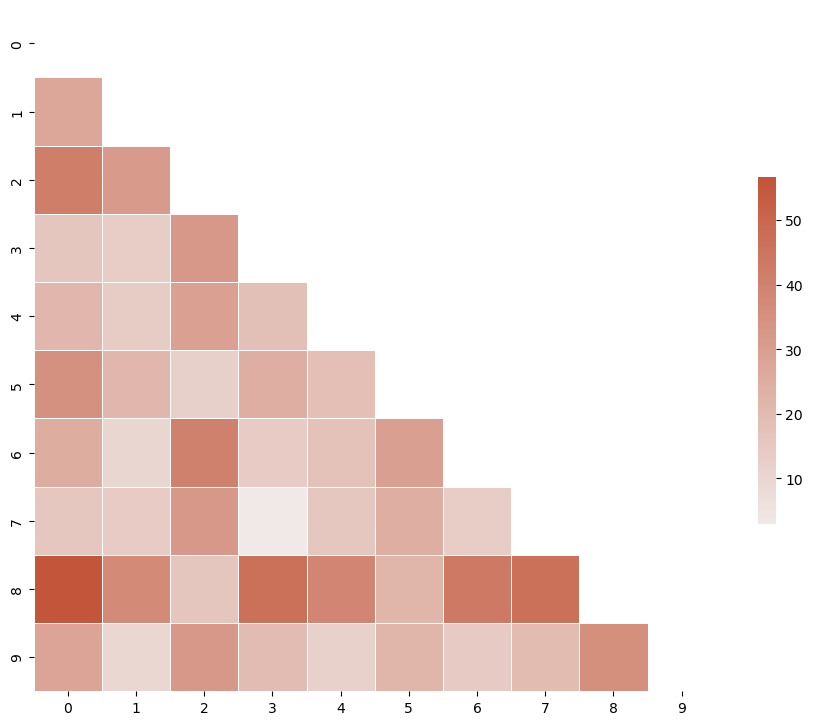

In [13]:
import seaborn as sns
print("Distance matrix of the first 10 data points...")
distances = d_matrix[:10, :10]

mask = np.triu(np.ones_like(distances, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(distances, mask=mask, cmap=cmap, vmax=distances.max(), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
from sklearn.manifold import MDS

mds = MDS(n_components=3,
          metric=True,
          dissimilarity="precomputed",
          random_state=2023,
          eps=1e-9)
%time mds_3d = mds.fit_transform(d_matrix)
visualize_3d(mds_3d, labels)

CPU times: total: 1h 43min 22s
Wall time: 5min 47s


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

Note: It works better with Manhatten distances - most likely the high dimension is a problem using the euclidean distance

In [15]:
print("Raw stress: ", mds.stress_)

Raw stress:  29572445.100653656


CPU times: total: 1h 30min 42s
Wall time: 5min 58s


C:\Users\sosoho\AppData\Local\Temp\ipykernel_13276\2821607423.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x[:, 0], y=x[:, 1],  s=100, alpha=0.8,


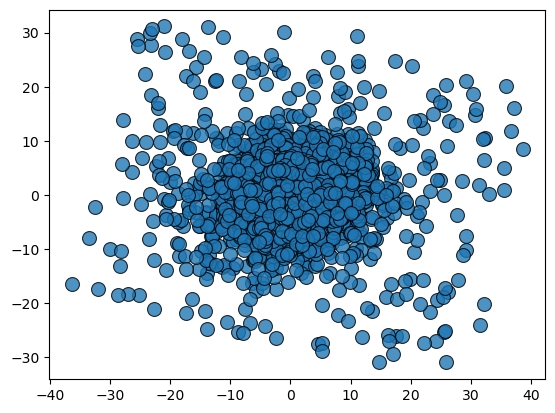

In [16]:
mds = MDS(n_components=2, eps=1e-9)
%time mds_2d = mds.fit_transform(features)
visualize_2d(mds_2d, labels)

### UMAP

In [17]:
try:
  import umap.umap_ as umap
except:
  !pip install umap-learn -q
  import umap.umap_ as umap

embedding_3d = umap.UMAP(n_components=3, n_neighbors=100, min_dist=0.1, metric='euclidean')
%time embedding_3d = embedding_3d.fit_transform(features)
visualize_3d(embedding_3d, labels)
embedding_3d.shape

CPU times: total: 4min 4s
Wall time: 21.2 s


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

(3000, 3)

CPU times: total: 3min 14s
Wall time: 14.5 s


C:\Users\sosoho\AppData\Local\Temp\ipykernel_13276\2821607423.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=x[:, 0], y=x[:, 1],  s=100, alpha=0.8,


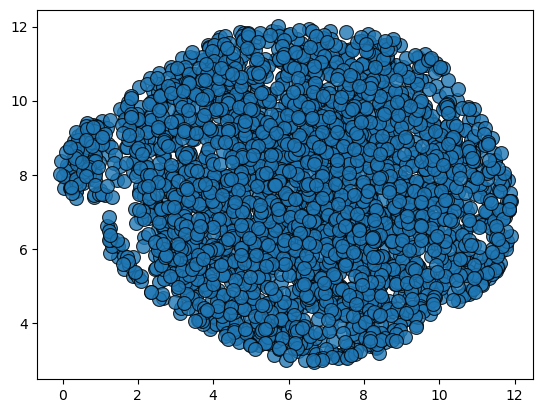

In [18]:
reducer = umap.UMAP(n_components=2, n_neighbors=150, min_dist=0.5, metric='euclidean')
%time umap_2d = reducer.fit_transform(features)
visualize_2d(umap_2d, labels)

# Bokeh plot

In [19]:
from io import BytesIO
from PIL import Image
import base64

def embeddable_image(image_url):
    # img_data = 255 - 15 * data.astype(np.uint8)
    # image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.Resampling.BICUBIC)
    image = Image.open(image_url).resize((128, 128), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()
    
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10, Category10, Set2

output_notebook()

embedding = reducer.transform(data['data'])
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

ModuleNotFoundError: No module named 'bokeh'

In [20]:
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df['geom'] = [str(x) for x in df['target']]
digits_df['Epk/Eacc'] = df['Epk/Eacc']
# digits_df['image'] = list(map(embeddable_image, df['images']))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=data['feature_names'],
                                       palette=Spectral10)

plot_figure = figure(
    title='UMAP projection of the Digits dataset',
    width=600,
    height=600,
    tools=('wheel_zoom, pan, reset')
)

# plot_figure.add_tools(HoverTool(tooltips="""
# <div>
#     <div>
#         <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
#     </div>
#     <div>
#         <span style='font-size: 16px; color: #224499'>Key:</span>
#         <span style='font-size: 18px'>@geom</span>
#     </div>
# </div>
# """))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='Epk/Eacc', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=10
)
show(plot_figure)

NameError: name 'embedding' is not defined

In [21]:
# df

In [22]:

# Step 2: Plot the UMAP embedding with color mapping
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=df['Epk/Eacc'], cmap='Set2', s=50)
plt.colorbar(scatter, label='epk')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Embedding Colored by epk')
plt.show()

NameError: name 'embedding' is not defined

<Figure size 1000x800 with 0 Axes>

In [23]:
import ipyvolume as ipv
import numpy as np
from matplotlib import cm

# Example data
x = np.random.rand(100)
y = np.random.rand(100)
z = np.random.rand(100)

# Example of specifying colors using a color map
color = np.random.rand(100)

# Use ipyvolume to plot with colors
ipv.quickscatter(x, y, z, color=color, size=3, marker='sphere')
ipv.show()


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [24]:
from matplotlib import cm

# Normalize your color values to [0, 1] range
norm = plt.Normalize(color.min(), color.max())

# Apply colormap
colors = cm.viridis(norm(color))

ipv.quickscatter(x, y, z, color=colors)
ipv.show()

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…